In [1]:
import math
import random

import gym
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
num_envs = 16
env_name = "Pendulum-v0"

envs = [gym.make(env_name) for _ in range(num_envs)]
test = gym.make(env_name)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [5]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)        
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [6]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape, 256),            
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        value = self.net(x)
        return value

In [17]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Frame {frame_idx} reward :{rewards[-1]}")
    plt.plot(rewards)
    plt.show()

def test_env(vis=False):
    state = test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        dist, _ = model(state)        
        next_state, reward, done, _ = test.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis:
            test.render(mode="rgb_array")
        total_reward += reward
    return total_reward

In [18]:
GAMMA = 0.99
GAE_LAMBDA = 0.95

In [19]:
# gae : Generalized advantage estimation
def compute_gae(next_value, rewards, masks, values, gamma=0.99, gae_lambda=GAE_LAMBDA):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = (rewards[step] + gamma * values[step + 1] * masks[step]) - values[step]
        gae = delta + gamma * gae_lambda * masks[step] * gae
        returns.insert(0, gae+values[step])
    return returns

In [20]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

In [21]:
def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [22]:
input_shape = envs[0].observation_space.shape[0]
n_actions = envs[0].action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(input_shape, n_actions, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
max_frames = 15000
frame_idx = 0
test_rewards = []

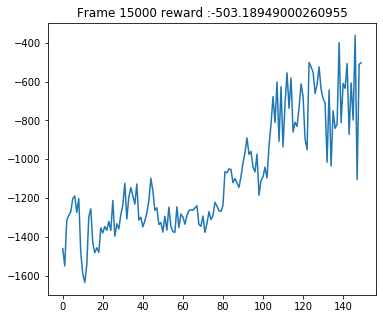

1200


In [24]:
states = np.concatenate([[envs[idx].reset()] for idx in range(num_envs)])
reset_count = 0
while frame_idx < max_frames:
    log_prob_list    = []
    value_list       = []
    reward_list      = []
    mask_list        = []
    states_list      = []
    actions_list     = []
    entropy          = 0
    
    for _ in range(num_steps):
        states_v = torch.tensor(states, dtype=torch.float).to(device)
        dists, values = model(states_v)

        actions = dists.sample()
        actions_np = actions.cpu().numpy()
        next_states, rewards, done, _ = zip(*[envs[idx].step(actions_np[idx]) for idx in range(num_envs)])
        next_states = np.asarray(next_states)
        rewards = np.asarray(rewards)
        done = np.asarray(done)
               
        log_prob = dists.log_prob(actions)
        entropy += dists.entropy().mean()

        log_prob_list.append(log_prob)
        value_list.append(values)

        rewards_t = torch.tensor(rewards, dtype=torch.float).unsqueeze(1).to(device)
        reward_list.append(rewards_t)

        mask_t = torch.tensor(1-done, dtype= torch.float).unsqueeze(1).to(device)
        mask_list.append(mask_t)
        
        states_list.append(states_v)
        actions_list.append(actions)
        
        '''
        if done:
            next_states = env.reset()
        '''
        for idx in range(num_envs):
            if done[idx] == True:
                reset_count += 1
                next_states[idx] = envs[idx].reset()

        states = next_states

        frame_idx += 1
        if frame_idx % 100 == 0:            
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            print(reset_count)
            if test_reward > threshold_reward: early_stop = True

    next_states_t = torch.tensor(next_states, dtype=torch.float).to(device)    
    _, next_value = model(next_states_t)    
    returns = compute_gae(next_value, reward_list, mask_list, value_list)
        
    '''
        >>> s
        tensor([1., 2., 3.])
        >>> a = []
        >>> a.append(s)
        >>> a
        [tensor([1., 2., 3.])]
        >>> a.append(s)
        >>> a
        [tensor([1., 2., 3.]), tensor([1., 2., 3.])]
        >>> torch.cat(a)
        tensor([1., 2., 3., 1., 2., 3.])
        >>> torch.stack(a)
        tensor([[1., 2., 3.],
                [1., 2., 3.]])
    '''
    
    log_prob_t = torch.cat(log_prob_list).detach()
    returns_t = torch.cat(returns).detach()
    values_t = torch.cat(value_list).detach()
    states_t = torch.cat(states_list)
    actions_t = torch.cat(actions_list)

    advantage = returns_t - values_t
  
    ppo_update(ppo_epochs, mini_batch_size, states_t, actions_t, log_prob_t, returns_t, advantage)   
    

In [25]:
test_env(vis=True)

-133.02188234365514